## Modelo datos estructurados
Este notebook desarrolla un primer modelo para resolver el problema de Petfinder. Empezamos haciendo un modelo inicial muy simple para ver la viabilidad de resolver el problema. Luego analizamos como se comporta la métrica kappa propuesta y vemos la matriz de confusión. Finalmente hacemos una optimizacin de hiperparametros evaluando con train/test y otra validando con 5 fold CV y testeando en el 20% de los datos

In [1]:
#Import de librerias basicas tablas y matrices
import numpy as np 
import pandas as pd 

#Gradient Boosting
import lightgbm as lgb

#Funciones auxiliares sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score #Metricas
from sklearn.preprocessing import OneHotEncoder

# from sklearn.utils import shuffle 

#Visualizacióon
from plotly import express as px

#Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix

import os

#Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump


In [2]:
#PONER LA ESTRUCUTRA DE CARPETAS COMO SE VE AQUI ABAJO !!!

In [3]:
# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la carpeta donde se ejecuta el notebook). 
# /UA_MDM_LDI_II/
# /UA_MDM_LDI_II/input
# /UA_MDM_LDI_II/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_LDI_II/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_LDI_II/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_LDI_II/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_LDI_II/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_LDI_II/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = ''

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split 

#PONER CUALQUIER SEMILLLA Y 20% DEL DATASTE USAMOS

In [4]:
#NUESTRO TODO ES TRAIN ... ENTONCES EN BASE A ESE DATASET HACEMOS TRAIN Y TEST

In [5]:
# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN)

In [6]:
#Columnas del dataset
dataset.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [7]:
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


## FEATURE ENGENEERING
Haremos modificaciones en el dataset para ver si mejora o no la fuerza predictiva del modelo base

In [8]:
#Imputar datos faltantes en Nombre
dataset.isnull().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

In [9]:
#Nuevas variables 

# Categorizacion de edad
# Crear cateogrias de edad para los animales
bins = [0, 12, 60, float('inf')]  # Define la cantidad de categorias y los limites de las mismas
labels = [1,2 ,3 ] #1='puppy' 2='adult' 3='senior'
dataset['AgeCategory'] = pd.cut(dataset['Age'], bins, labels=labels, right=False)

# Combinacion para Breed
# Create una nueva variable que indique si el animal es de raza pura o mestizo
dataset['Breed'] = dataset.apply(lambda row: 2 if row['Breed2'] != 0 else 1, axis=1)

# Color
# analizar si el animal tiene mas de un color ( MIXTO O PURO)
dataset['IsMultiColored'] = dataset.apply(lambda row: 1 if row['Color2'] != 0 or row['Color3'] != 0 else 0, axis=1)

#Name
# Crear variable que indique si el animal tiene o no nombre
dataset['Name'].fillna('No Name Yet', inplace=True)
dataset['Name'] = dataset['Name'].replace('', 'No Name Yet')
dataset['name_code'] = dataset['Name'].apply(lambda x: 1 if x != 'No Name Yet' else 0)

# Creación de nuevas características
dataset['Age_log'] = np.log1p(dataset['Age']) #logaritmo de la edad
dataset['PhotoAmt_log'] = np.log1p(dataset['PhotoAmt']) #logaritmo de la cantidad de fotos
dataset['VideoAmt_log'] = np.log1p(dataset['VideoAmt']) #logaritmo de la cantidad de videos

# Interacciones entre características
dataset['Age_PhotoAmt'] = dataset['Age'] * dataset['PhotoAmt'] #relación entre la edad de la mascota y la cantidad de fotos
dataset['Age_VideoAmt'] = dataset['Age'] * dataset['VideoAmt'] #relación entre la edad de la mascota y la cantidad de videos

# Agregaciones y agrupaciones
dataset['Breed1_mean_Age'] = dataset.groupby('Breed1')['Age'].transform('mean') #promedio de edad por raza
dataset['Breed1_mean_PhotoAmt'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean') #promedio de fotos por raza



In [10]:
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Breed,IsMultiColored,name_code,Age_log,PhotoAmt_log,VideoAmt_log,Age_PhotoAmt,Age_VideoAmt,Breed1_mean_Age,Breed1_mean_PhotoAmt
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,1,1.386294,0.693147,0.0,3.0,0,7.532164,4.052632
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,0.693147,1.098612,0.0,2.0,0,6.282194,4.085851
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,1,0.693147,2.079442,0.0,7.0,0,7.541421,3.863675
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,1,1.609438,2.197225,0.0,32.0,0,7.541421,3.863675
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,0,1,0.693147,1.386294,0.0,3.0,0,7.541421,3.863675


In [11]:
# Supongamos que 'dataset' es tu DataFrame

# Listar variables numéricas
numeric_features = dataset.select_dtypes(include=['number']).columns.tolist()
print("Variables numéricas:", numeric_features)

# Listar variables categóricas
categorical_features = dataset.select_dtypes(include=['object', 'category']).columns.tolist()
print("Variables categóricas:", categorical_features)

Variables numéricas: ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed', 'Breed', 'IsMultiColored', 'name_code', 'Age_log', 'PhotoAmt_log', 'VideoAmt_log', 'Age_PhotoAmt', 'Age_VideoAmt', 'Breed1_mean_Age', 'Breed1_mean_PhotoAmt']
Variables categóricas: ['Name', 'RescuerID', 'Description', 'PetID', 'AgeCategory']


In [12]:
#Este fragmento de código define una función add_new_variables_with_lgbm que agrega nuevas variables a un conjunto de datos utilizando un modelo de LightGBM. Aquí está el desglose paso a paso:
def add_new_variables_with_lgbm(dataset):
    # Selección de características numéricas y categóricas:
    numeric_features = ['Age', 'VideoAmt', 'PhotoAmt', 'AgeCategory', 'IsMultiColored', 'name_code','Age_log', 'PhotoAmt_log', 'VideoAmt_log', 'Age_PhotoAmt', 'Age_VideoAmt', 'Breed1_mean_Age', 'Breed1_mean_PhotoAmt']
    categorical_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3']

    # Codificación de características categóricas:
    encoded_features = pd.get_dummies(dataset[categorical_features], columns=categorical_features, prefix=categorical_features)

    # Concatenación de características numéricas y codificadas:
    processed_dataset = pd.concat([dataset[numeric_features], encoded_features], axis=1)

    # Creación del conjunto de datos de entrenamiento:
    target = dataset['AdoptionSpeed']
    train_data = lgb.Dataset(processed_dataset, label=target, params={'verbose': -1})

    # Definición de parámetros de LightGBM
    lgb_params = {
        'objective': 'multiclass',
        'num_class': 5,  
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
    }

    # Entrenamiento del modelo LightGBM:
    model = lgb.train(lgb_params, train_data)

    # Obtención de predicciones para cada muestra:
    predictions = model.predict(processed_dataset)

    # Adición de nuevas variables basadas en las predicciones:
    for class_num in range(5):  
        dataset[f'prediction_class_{class_num}'] = predictions[:, class_num]

    return dataset

# Llamada a la función con el DataFrame:
df_with_new_variables = add_new_variables_with_lgbm(dataset.copy())  # Usar dataset.copy() para evitar modificar el DataFrame original

In [13]:
df_with_new_variables

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,VideoAmt_log,Age_PhotoAmt,Age_VideoAmt,Breed1_mean_Age,Breed1_mean_PhotoAmt,prediction_class_0,prediction_class_1,prediction_class_2,prediction_class_3,prediction_class_4
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.0,3.0,0,7.532164,4.052632,0.037444,0.262202,0.341899,0.174184,0.184271
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.0,2.0,0,6.282194,4.085851,0.038419,0.394528,0.266756,0.123176,0.177121
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.0,7.0,0,7.541421,3.863675,0.008326,0.269072,0.336809,0.333211,0.052583
3,1,Miko,4,307,0,2,1,2,0,2,...,0.0,32.0,0,7.541421,3.863675,0.002474,0.070148,0.260799,0.377054,0.289525
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.0,3.0,0,7.541421,3.863675,0.008175,0.353589,0.340138,0.199402,0.098695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,No Name Yet,2,266,0,3,1,0,0,2,...,0.0,6.0,0,6.724546,4.211337,0.010775,0.250261,0.247416,0.219092,0.272456
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,0.0,180.0,0,6.282194,4.085851,0.001732,0.027652,0.254474,0.168685,0.547455
14990,2,Monkies,2,265,266,3,5,6,7,3,...,0.0,10.0,0,6.282194,4.085851,0.021769,0.397967,0.237364,0.200740,0.142159
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,0.0,27.0,0,6.724546,4.211337,0.017490,0.108205,0.143727,0.207379,0.523199


In [14]:
dataset=df_with_new_variables

In [15]:

#Separo un 20% para test estratificado opr target
#PERO MANTENEMOS LA PROPORCION
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.AdoptionSpeed)

In [16]:
#Armo listas con features de texto y numericas
char_feats = [f for f in dataset.columns if dataset[f].dtype=='O']
numeric_feats = [f for f in dataset.columns if dataset[f].dtype!='O']

In [17]:
#Lista de features numericas
#ESTE EJEMPLO SE HACE SOLO CON VARIABLES NUMERICAS
char_feats

['Name', 'RescuerID', 'Description', 'PetID']

In [18]:

#Defino features a usar en un primer modelo de prueba
features = ['Type',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'VideoAmt',
 'PhotoAmt',
 'AgeCategory',
 'Breed',
 'IsMultiColored',
 'name_code',
 'Age_log',
 'PhotoAmt_log',
 'VideoAmt_log',
 'Age_PhotoAmt',
 'Age_VideoAmt',
 'Breed1_mean_Age',
 'Breed1_mean_PhotoAmt',
 'prediction_class_0',
 'prediction_class_1',
 'prediction_class_2',
 'prediction_class_3',
 'prediction_class_4']

label = 'AdoptionSpeed'

In [19]:
train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,VideoAmt_log,Age_PhotoAmt,Age_VideoAmt,Breed1_mean_Age,Breed1_mean_PhotoAmt,prediction_class_0,prediction_class_1,prediction_class_2,prediction_class_3,prediction_class_4
10070,1,The Adorable Trio,2,307,307,1,1,0,0,2,...,0.0,16.0,0,7.541421,3.863675,0.001666,0.156206,0.263296,0.495640,0.083192
13397,1,Perky,12,307,0,2,2,0,0,1,...,0.0,36.0,0,7.541421,3.863675,0.009224,0.042882,0.125914,0.164206,0.657773
14656,1,Bernard Boy,2,307,307,1,1,2,7,2,...,0.0,2.0,0,7.541421,3.863675,0.031791,0.239136,0.251731,0.204903,0.272439
5596,1,Oreo 1,2,307,307,1,3,0,0,2,...,0.0,4.0,0,7.541421,3.863675,0.026451,0.289790,0.304206,0.195960,0.183593
13463,2,Anak Kucing,4,265,0,3,1,2,0,2,...,0.0,8.0,0,6.282194,4.085851,0.015868,0.175384,0.211173,0.171354,0.426221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,2,Maxine,8,265,299,2,1,2,0,2,...,0.0,16.0,0,6.282194,4.085851,0.010745,0.111504,0.274366,0.151013,0.452373
10249,1,Browny,2,307,0,2,6,7,0,1,...,0.0,2.0,0,7.541421,3.863675,0.024203,0.123720,0.360015,0.255282,0.236780
12468,1,Midnight,2,307,307,1,1,0,0,2,...,0.0,4.0,0,7.541421,3.863675,0.022272,0.233070,0.339302,0.175189,0.230167
1081,1,Boxer,2,307,307,1,1,2,7,2,...,0.0,4.0,0,7.541421,3.863675,0.024658,0.212246,0.385915,0.149170,0.228011


In [20]:
#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

In [21]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
#HACEMOS LGBM POR DEFECTO COMO VIENE
lgb_params = params = {
                        'objective': 'multiclass',#EL PROBLEMA ES UNA MULTICPLASE 
                        'num_class': len(y_train.unique())
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

In [22]:
#Obtengo las predicciones sobre el set de test. El modelo me da una lista de probabilidades para cada clase y tomo la clase con mayor probabilidad con la funcion argmax
y_pred = lgb_model.predict(X_test).argmax(axis=1)#CON ARGMAX OBTENGO LA PREDICCION MAS GRANDE DE LAS CATEGORIAS OSEA LA GANADORA

#Calculo el Kappa
cohen_kappa_score(y_test,y_pred, weights = 'quadratic')
#MI MODELO DA UN 0.31 DE SCORE 
#RECORDAR QUE AL SER UN MULTICLASE EL PREDICT ME TRAE 5 COLUMNAS ( PROBABILIDAD DEL MODELO A CADA UNA DE LAS CLASES )




0.4792861953925617

In [23]:
#Muestro la matriz de confusión
display(plot_confusion_matrix(y_test,y_pred))
#SI OBTENGO UNA DIAGONAL MUY FUERTE AMARILLA ES PQ PREDIJO BIEN EL MODELO 

In [24]:
#Vamos a ponewr en perspectiva el score de Kappa


#Cual es el score perfecto? Evaluo la clase real contra si misma. Es decir, el caso en que el modelo establece todas las clases en su valor real
cohen_kappa_score(y_test,y_test, weights = 'quadratic')

1.0

In [25]:
#Como se veria la matriz de confusión PERO ESTA ES LA PERFECTA
display(plot_confusion_matrix(y_test,y_test))

In [26]:
#SIMULACIONES

In [27]:
#Pruebo un modelo alternativo donde en vez de usar la version multiclass real de lightGBM utilizo One vs All

lgb_params = params = {
                        'objective': 'multiclassova', # ESTA HACE MUCHAS LOGITICAS COMBINADAS PERO SIEMPRE DECIDE QUEDARSE CON UNA 
                        'num_class': len(y_train.unique())
                        }


lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

In [28]:
#MAtriz de confusion y Kappa dfe OVA
y_pred = lgb_model.predict(X_test).argmax(axis=1)

display(plot_confusion_matrix(y_test,y_pred))

{'kappa':cohen_kappa_score(y_test,
                y_pred,
                weights = 'quadratic'),
 'accuracy':accuracy_score(y_test,y_pred),
 'balanced_accuracy':balanced_accuracy_score(y_test,y_pred)}




{'kappa': 0.47943098868329026,
 'accuracy': 0.559186395465155,
 'balanced_accuracy': 0.5400984254594114}

In [29]:
#USAR MULTINOVA MEJORA KAPPA OSEA MI MODELO SE ACERCA MAS AL ORIG

## Optimizacion de hiperparametros modelo train/test

In [30]:
#AHORA SUMAMOS HIPERPARAMETROS PARA VER QUE PASA CON LGBM

In [31]:

#Funcion que vamos a optimizar. Optuna requiere que usemos el objeto trial para generar los parametros a optimizar
def lgb_objective(trial):
    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Genero objeto dataset de entrenamiento
    lgb_train_dataset = lgb.Dataset(data=X_train,
                                    label=y_train)

    #ajuste de modelo
    lgb_model = lgb.train(lgb_params,
                        lgb_train_dataset)
    
    #Devuelvo el score en test
    return(cohen_kappa_score(y_test,lgb_model.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

In [32]:
#Defino el estudio a optimizar
study = optuna.create_study(direction='maximize', #buscamos maximizar la metrica
                            storage="sqlite:///work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass", #nombre del experimento
                            load_if_exists=True) #continuar si ya existe

#Corremos 100 trials para buscar mejores parametros
study.optimize(lgb_objective, n_trials=100)

[I 2024-08-24 08:49:38,495] Using an existing study with name '04 - LGB Multiclass' instead of creating a new one.
[I 2024-08-24 08:49:41,204] Trial 1484 finished with value: 0.483977935024807 and parameters: {'lambda_l1': 8.893235266261993e-05, 'lambda_l2': 8.139808376756384e-08, 'num_leaves': 27, 'feature_fraction': 0.900366996804788, 'bagging_fraction': 0.5540718542041744, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 200 with value: 1.0.
[I 2024-08-24 08:49:42,140] Trial 1485 finished with value: 0.4828837155360979 and parameters: {'lambda_l1': 4.3823043241370415e-05, 'lambda_l2': 2.7551146094036744e-08, 'num_leaves': 2, 'feature_fraction': 0.4108398209788985, 'bagging_fraction': 0.56681327629941, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 200 with value: 1.0.
[I 2024-08-24 08:49:44,906] Trial 1486 finished with value: 0.49209747094967693 and parameters: {'lambda_l1': 0.00012566168816623957, 'lambda_l2': 1.1794015003009835e-07, 'num_leaves': 17, 'featur

In [33]:
#corriendo esto en terminal deberia ver el dashboard 
#optuna-dashboard sqlite:///work/db.sqlite3 --artifact-dir /work/optuna_artifacts --port 8081

In [34]:
#Obtenemos mejor resultado
study.best_params

{'lambda_l1': 0.00016911420117746327,
 'lambda_l2': 3.0291532676782044e-07,
 'num_leaves': 23,
 'feature_fraction': 0.9710839320963843,
 'bagging_fraction': 0.6006057268679922,
 'bagging_freq': 6,
 'min_child_samples': 16}

In [35]:
#Vamos a replicar el resultado de la optimizacion reentrenando el modelo con el mejor conjunto de hiperparametros
#Generamos parametros incluyendo los fijos y la mejor solución que encontro optuna
lgb_params = {
    'objective': 'multiclass',
    'verbosity': -1,
    'num_class': len(y_train.unique())
}

# Update lgb_params with study.best_params
lgb_params.update(study.best_params)

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model = lgb.train(lgb_params,
                    lgb_train_dataset)

#Muestro matriz de confusion y kappa
display(plot_confusion_matrix(y_test,lgb_model.predict(X_test).argmax(axis=1)))

cohen_kappa_score(y_test,lgb_model.predict(X_test).argmax(axis=1),
                             weights = 'quadratic')


0.48313067679337285

In [36]:
#A PARTIR DE OPTUNA (OPTIMIZACION BAYESIANA) ES LO MEJOR TENGO ENTENDIDO, ECONTRE LOS MEJORES VALORES HIPERPARMTROS
#Y ESO MEJORO KAPPA 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar visualizaciones
sns.set(style="whitegrid")

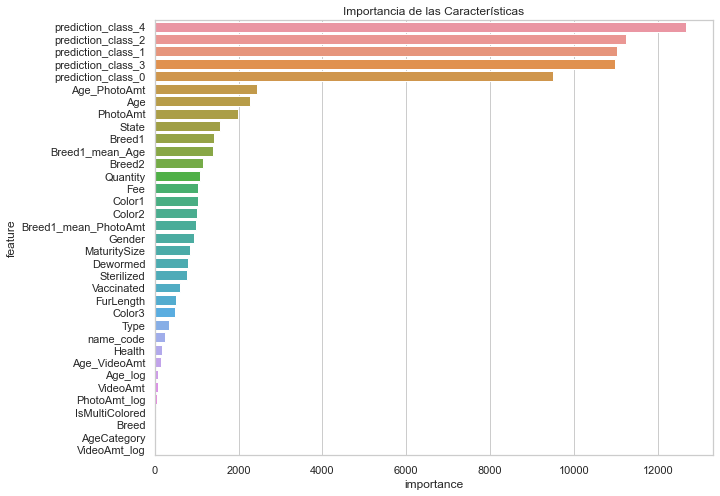

In [44]:
# Obtener la importancia de las características
importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Crear un DataFrame para mostrar las importancias
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Visualizar las importancias
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importancia de las Características')
plt.show()

## Modelo con cross validation y conjunto de test

In [37]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_lgb_objective(trial):

    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        #Dataset in fold (donde entreno) 
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        #Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        #Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                callbacks=[lgb.early_stopping(10, verbose=False)],
                                feval = lgb_custom_metric_kappa
                                )
        
        #Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        #Se predice el 20% de los datos que separe para tes y no uso para entrenar en ningun fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test)
        
        #Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [38]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass CV",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=100)

<ipython-input-38-3ba8469af45f>:2: ExperimentalWarning:

FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-08-24 08:52:19,174] Using an existing study with name '04 - LGB Multiclass CV' instead of creating a new one.
<ipython-input-37-1c6539846d38>:86: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

<ipython-input-37-1c6539846d38>:94: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-08-24 08:52:33,306] Trial 571 finished with value: 0.5218002241872144 and parameters: {'lambda_l1': 5.098732379860573, 'lambda_l2': 9.95987616606563, 'num_leaves': 22, 'feature_fraction': 0.5950486950257636, 'bagging_fraction': 0.416649811220159, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 45 with value: 1.0.
<ipython-input-37-1c6539846d38>:86: ExperimentalWarning:

upload_artifact

Para ver el optuna dashboard tengo que correr este comando en la terminal

In [39]:
!pip install kaleido


In [40]:
!optuna-dashboard sqlite://work/db.sqlite3 --artifact-dir ../work/optuna_artifacts --port 8081

Traceback (most recent call last):
  File "c:\users\s1093678\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\s1093678\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\s1093678\Anaconda3\Scripts\optuna-dashboard.exe\__main__.py", line 7, in <module>
  File "c:\users\s1093678\anaconda3\lib\site-packages\optuna_dashboard\_cli.py", line 119, in main
    storage = get_storage(args.storage, storage_class=args.storage_class)
  File "c:\users\s1093678\anaconda3\lib\site-packages\optuna_dashboard\_storage_url.py", line 59, in get_storage
    return guess_storage_from_url(storage)
  File "c:\users\s1093678\anaconda3\lib\site-packages\optuna_dashboard\_storage_url.py", line 84, in guess_storage_from_url
    return get_rdb_storage(storage_url)
  File "c:\users\s1093678\anaconda3\lib\site-packages\optuna_dashboard\_storage_url.py", line 91, in get_rdb_storage
    return RDBStorage(st

In [41]:
#para proxima clase hacer feature engeneering (agregar feature, health , colores, etc) pq hasta aca solo s ehizo con los variables numericas
#TENER UN MODELO CANDIDATO TABULAR PARA SEGUIR ADELANTE 
#VAMOS A VER LA EJECUCION DE UN MODELO PARA BUCAR HIPERPARAMETROS ETC 
#DAR CON UN MODELO GANADOR
